## Notebook Description:
In this notebook we preformed initial analysis of the data to acheive better understanding and to identify any patterns, trends, or relationships between the variables. We examined distributions, correlations, data transformations and more

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
from scipy import stats

In [226]:
all_df = pd.read_pickle("all_df.pkl")

In [227]:
# adding a column that indicates if a patient has and record with the label=1
all_df["any_sepsis"] = all_df.groupby('patient id')['SepsisLabel'].transform(lambda x: 1 if x.any() else 0)

In [273]:
wa_duplicates = all_df.drop_duplicates(subset=["patient id"])
wa_duplicates[["Age", "Gender", "Unit1", "Unit2", "HospAdmTime"]].astype(str).describe()

,Age,Gender,Unit1,Unit2,HospAdmTime
count,20000,20000,20000,20000,20000
unique,4816,2,3,3,7555
top,67.0,1,nan,nan,-0.02
freq,306,11110,7686,7686,1964


In [275]:
wa_duplicates["HospAdmTime"].describe()

count    20000.000000
mean       -50.975196
std        140.077631
min      -5366.860000
25%        -42.565000
50%         -5.950000
75%         -0.040000
max         17.340000
Name: HospAdmTime, dtype: float64

## SIRS measure

In [87]:
condition = (np.isnan(all_df['Temp']) & np.isnan(all_df['HR']) & np.isnan(all_df['Resp']) & np.isnan(all_df['WBC']))
all_df['hasSIRS'] = np.where(condition, 1, 0)
all_df['hasSIRS'].value_counts()

hasSIRS
0    695525
1     71359
Name: count, dtype: int64

In [88]:
a = all_df['WBC'] * 10**3
a.describe()

count     49059.000000
mean      11453.655598
std        7487.563950
min         100.000000
25%        7600.000000
50%       10300.000000
75%       13750.000000
max      440000.000000
Name: WBC, dtype: float64

In [89]:
all_df['WBC'].describe()

count    49059.000000
mean        11.453656
std          7.487564
min          0.100000
25%          7.600000
50%         10.300000
75%         13.750000
max        440.000000
Name: WBC, dtype: float64

In [228]:
condition_temp=(all_df['Temp'] > 38) | ( all_df['Temp'] < 36)
condition_HR=(all_df['HR'] > 90)
condition_Resp=(all_df['Resp'] > 20) | ( all_df['PaCO2'] < 32)
condition_wbc=(all_df['WBC']* 10**3 > 12000) |( all_df['WBC']* 10**3 < 4000)

all_df['SIRS_score'] = np.where(condition_temp, 1, 0)+np.where(condition_HR, 1, 0)+np.where(condition_Resp, 1, 0)+np.where(condition_wbc, 1, 0)
all_df['SIRS_score'] = np.where(all_df['SIRS_score'] >= 2, 1, 0)

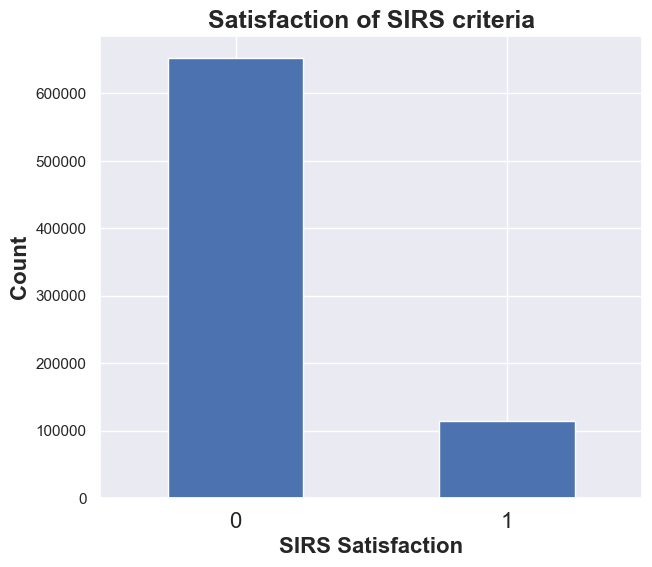

In [233]:
# sns.histplot(data=all_df, x="SIRS_score", binwidth=0.5)
# plt.title("SIRS score in the dataset")
# plt.grid(False)
# plt.show()

all_df['SIRS_score'].value_counts().plot.bar()
plt.ylabel('Count', fontweight = "bold", fontsize=16)
plt.xticks(rotation=0, ha='center', fontsize=16)
plt.xlabel('SIRS Satisfaction', fontweight = "bold", fontsize=16)
plt.title("Satisfaction of SIRS criteria", fontweight = "bold", fontsize=18)
plt.show()

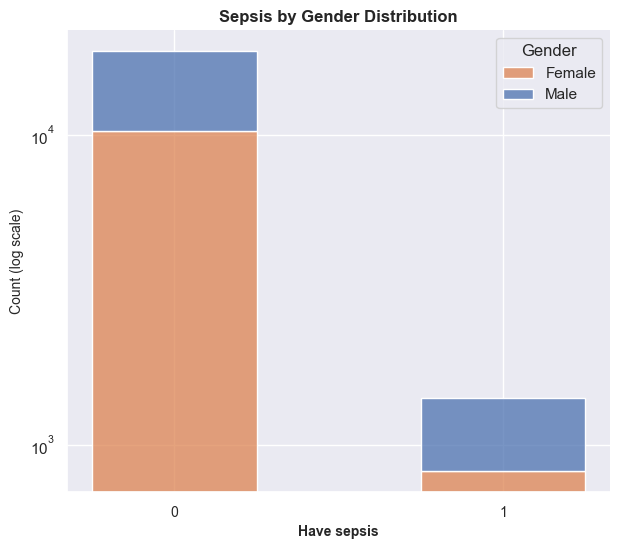

In [225]:
sns.histplot(data=all_df.drop_duplicates(subset=["patient id", "Gender", "any_sepsis"]), x="any_sepsis", hue="Gender", multiple="stack", binwidth=0.5, binrange=(-0.25, 1.25))
plt.xticks([0,1], ha='center', fontsize=10)
plt.yscale('log')
sns.despine()
plt.legend(title="Gender", labels=["Female", "Male"])
plt.xlabel('Have sepsis', fontweight = "bold")
plt.ylabel("Count (log scale)")
plt.title("Sepsis by Gender Distribution", fontweight = "bold")
plt.show()

## Correlations to the target 

C:\Users\maaya\AppData\Local\Temp\ipykernel_21980\219283348.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="p-value")


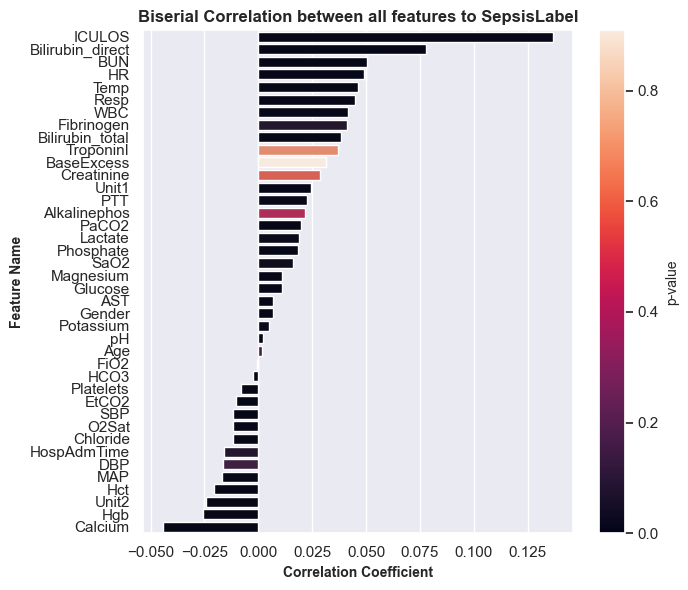

In [180]:
corr_values = {}
p_values = {}
for col in all_df.columns:
    if col not in ["SepsisLabel", "patient id", "any_sepsis"]:
        non_nan = all_df.dropna(subset=[col])
        corr, pval = pointbiserialr(non_nan[col], non_nan["SepsisLabel"])
        corr_values[col] = corr
        p_values[col] = pval

# Sort the dictionaries by absolute correlation values
sorted_values = sorted(zip(corr_values.values(), p_values.values(), corr_values.keys()), key=lambda x: x[0], reverse=True)
corr_series = pd.Series([x[0] for x in sorted_values], index=[x[2] for x in sorted_values])
p_series = pd.Series([x[1] for x in sorted_values], index=[x[2] for x in sorted_values])

# Create color mapping based on p-values
vmax = max(p_values.values())
cmap = sns.cm.rocket
p_colors = [cmap(p/vmax) for p in p_values.values()]

# Create figure and axis objects
fig, ax = plt.subplots()

# Create bar plot of correlation values
sns.barplot(x=corr_series.values, 
            y=corr_series.index,
            palette=p_colors)

# Add legend for color mapping
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=vmax))
sm.set_array([])
plt.colorbar(sm, label="p-value")

# Set plot title and labels
ax.set_title("Biserial Correlation between all features to SepsisLabel", fontweight = "bold")
ax.set_xlabel("Correlation Coefficient", fontweight = "bold")
ax.set_ylabel("Feature Name", fontweight = "bold")

plt.tight_layout()

#sns.set(rc={'font.size':10, 'axes.titlesize':12, 'axes.labelsize':10})

plt.show()

## Correlations between features

In [171]:
def plot_corr(feature1, feature2, seperator, seperator_vals):
    for val in seperator_vals:
        plt.scatter(x=all_df[all_df[seperator] == val][feature1], y=all_df[all_df[seperator] == val][feature2], label = f"{seperator} {val}")
    plt.legend()
    plt.title(f"{feature1} vs {feature2}")
    plt.show()

In [234]:
corrs_p_values = {}
for i, col1 in enumerate(all_df.columns):
    for j, col2 in enumerate(all_df.columns):
        not_nan_df = all_df.dropna(subset=[col1,col2])
        if i < j:
            corr, p = stats.pearsonr(not_nan_df[col1], not_nan_df[col2])
            if corr >= 0.5 or corr <= -0.5:
                corrs_p_values[(col1, col2)] = (corr, p)

In [235]:
corrs_p_values

{('SBP', 'MAP'): (0.7817974980713378, 0.0),
 ('SBP', 'DBP'): (0.5421353875821167, 0.0),
 ('MAP', 'DBP'): (0.8514820342348233, 0.0),
 ('BaseExcess', 'HCO3'): (0.8495152245268334, 0.0),
 ('BaseExcess', 'pH'): (0.6532852726817399, 0.0),
 ('HCO3', 'PaCO2'): (0.5369497405849637, 0.0),
 ('BUN', 'Creatinine'): (0.631362098483196, 0.0),
 ('BUN', 'Phosphate'): (0.543122576085213, 0.0),
 ('Creatinine', 'Phosphate'): (0.5454326737236533, 0.0),
 ('Bilirubin_direct', 'Bilirubin_total'): (0.9524445030170607, 0.0),
 ('Hct', 'Hgb'): (0.9537081162670719, 0.0),
 ('Unit1', 'Unit2'): (-1.0, 0.0)}

In [236]:
corrs = all_df.corr()
corr_matrix = np.triu(corrs, k=1)
corr_filtered = pd.DataFrame(corr_matrix, columns=all_df.columns, index=all_df.columns)
corr_filtered = corr_filtered[((corr_filtered >= 0.5) & (corr_filtered != 1)) | (corr_filtered <=-0.5)]
dict_filtered = corr_filtered.to_dict()

not_nan_corrs = {}
for k_out,v_out in dict_filtered.items():
    for k_in, v_in in v_out.items():
        if not math.isnan(v_in):
            not_nan_corrs[(k_out, k_in)] = v_in

In [239]:
del not_nan_corrs[('Unit2', 'Unit1')]

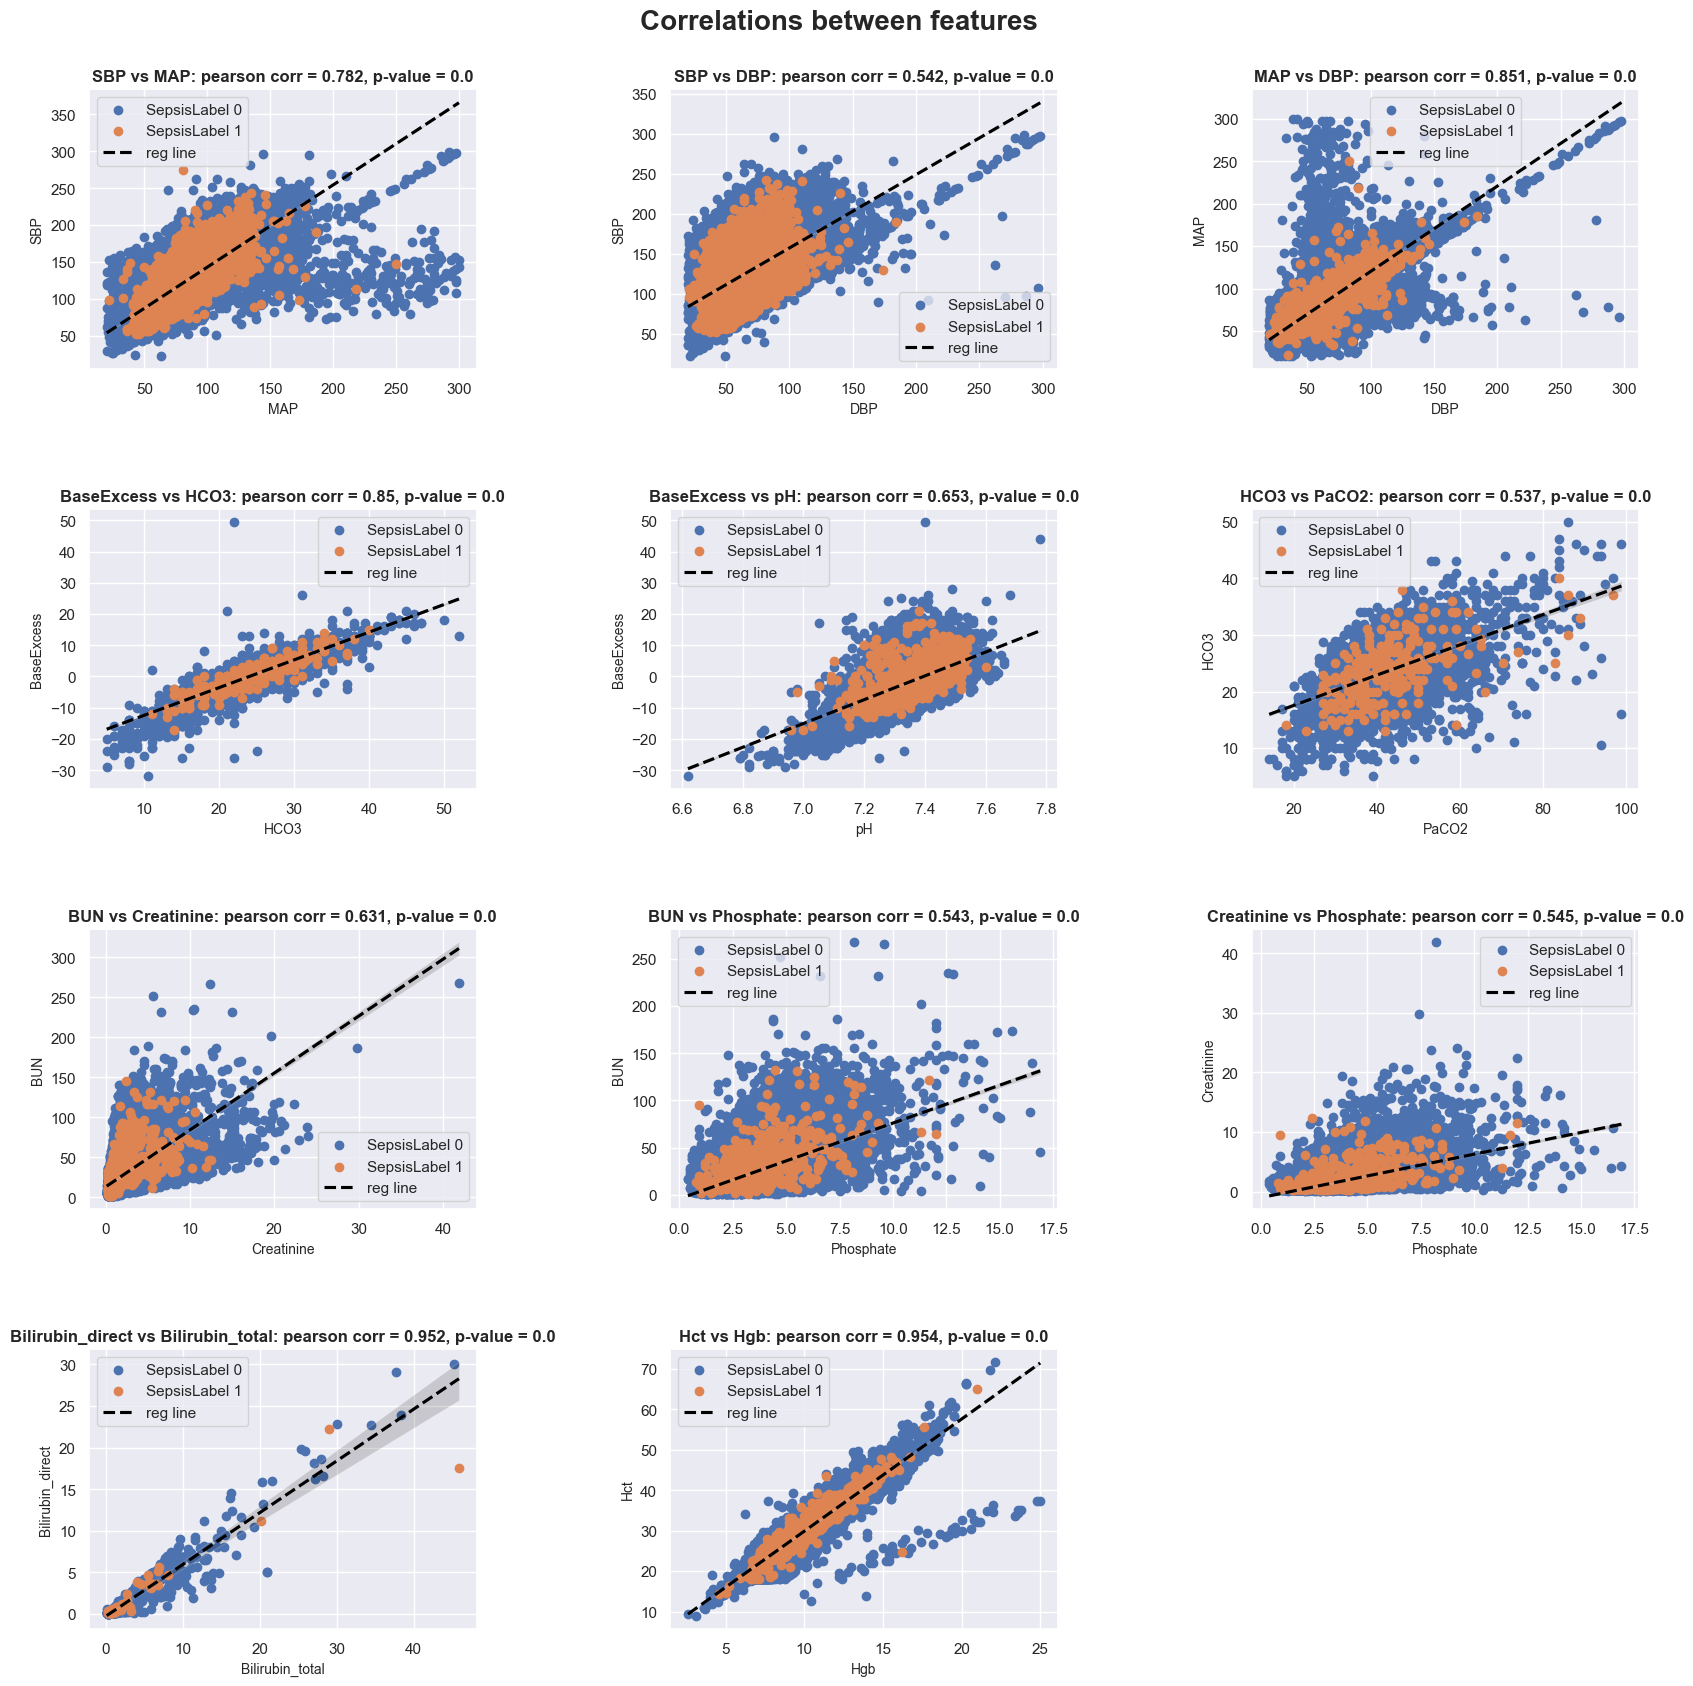

In [269]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5, hspace=0.5)
fig.suptitle("Correlations between features", fontsize=20, fontweight="bold", y=0.92)

seperator = "SepsisLabel"
for i, pair in enumerate(not_nan_corrs.keys()):
    feature1, feature2 = pair
    ax = axes[i // 3, i % 3]
    for val in all_df[seperator].unique():
        ax.scatter(x=all_df[all_df[seperator] == val][feature1], y=all_df[all_df[seperator] == val][feature2], label=f"{seperator} {val}")
    sns.regplot(x=feature1, y=feature2, data=all_df, ax=ax, scatter=False, color='black', label="reg line", line_kws={'linestyle':'--'})
    ax.legend()
    ax.set_title(f"{feature2} vs {feature1}: pearson corr = {round(not_nan_corrs[(feature1, feature2)], 3)}, p-value = 0.0", fontweight="bold")

fig.delaxes(axes[3,2])
    
plt.show()